# Stock Market News and Sentiment Analysis Backtesting

In [78]:
# Libraries
from eod import EodHistoricalData
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import nltk
from textblob import TextBlob
import numpy as np
import random
import plotly.express as px




# Importing and assigning the api key
with open("../../eodHistoricalData-API.txt", "r") as f:
    api_key = f.read()
    
# EOD Historical Data client
client = EodHistoricalData(api_key)

## Retrieving News

In [28]:
def getNews(ticker, days):
    """
    Retrieves financial news over the course of a specified number of days for
    a given stock ticker.
    """

    # List of news
    news = []
    
    # How many days back to retrieve
    ago = datetime.now() - timedelta(days=days)

    # Getting news over the course of a year
    for i in tqdm(range(10, days, 10)):

        # Grabbing the news
        resp = client.get_financial_news(
            s=ticker,
            from_=(ago+timedelta(days=i-10)).strftime("%Y-%m-%d"),
            to=(ago+timedelta(days=i)).strftime("%Y-%m-%d"),
            limit=50
        )

        # Adding to the news list
        news.extend(resp)
        
    # Filtering out irrelevant news
    lst = [i for i in news if sum(x in {ticker.lower()} for x in nltk.word_tokenize(i['title'].lower()))>=1]
    
    # Formatting the date
    df = pd.DataFrame(lst)
    
    df['date'] = df['date'].apply(lambda x: x[:10])
    
    return df

In [29]:
# Retrieving financial news
news = getNews("AMD", 365)

100%|██████████| 36/36 [00:21<00:00,  1.65it/s]


## Retrieving Price History

In [43]:
# Date
ago = datetime.now() - timedelta(days=365)

# Prices
prices = pd.DataFrame(client.get_prices_eod("AMD", from_=ago.strftime("%Y-%m-%d")))

# Set index
prices = prices.set_index('date', drop=True)

## Sentiment Analysis

In [32]:
news['sentiment'] = news['title'].apply(lambda x: TextBlob(x.lower()).sentiment[0])

In [33]:
news[['sentiment', 'title']].tail(50)

,sentiment,title
360,0.000000,AMD earnings preview: EPYC processor momentum ...
361,-0.125000,Dow Jones Stalls As Growth Stocks Suffer; Dona...
362,0.000000,AMD Reports Third Quarter 2021 Financial Results
363,0.136364,AMD Third-Quarter Earnings Live Blog
364,0.000000,AMD Reports Third Quarter 2021 Financial Results
365,0.000000,"Dow Jones Futures: Market Rally Stalls, Donald..."
366,0.160000,AMD Stock In Record High Territory As Data-Cen...
367,0.000000,AMD shares see boost after Q3 earnings
368,-0.050000,AMD Gives Another Bullish Forecast; Data Cente...
369,0.400000,Advanced Micro Devices (AMD) Q3 Earnings and R...


# Getting Positions

In [34]:
def sentimentPositions(val, thresh=0.1):
    """
    Returns position as 1, -1, or 0 for Buy, Sell, and Do Nothing respectively based
    on the given value and threshold.
    """
    if val > thresh:
        return 1
    elif val< -thresh:
        return -1
    else:
        return 0

In [69]:
# Grouping together sentiment scores from the same day
df = news.groupby('date')[['sentiment']].mean()

# Getting positions
df['sentiment_positions'] = df['sentiment'].apply(
    lambda x: sentimentPositions(x, thresh=0.1)
)

# Combining DFs

In [70]:
# Merging price history and sentiment positions
df = df.merge(
    prices, 
    right_index=True, 
    left_index=True, 
    how='outer'
)

# Filling in empty values with their most recent value for positions
df['sentiment_positions'] = df['sentiment_positions'].fillna(
    method='ffill'
)

# Dropping the NaNs in the beginning
df[['sentiment_positions', 'adjusted_close']].dropna()

,sentiment_positions,adjusted_close
date,,
2020-12-02,1.0,93.74
2020-12-03,1.0,92.31
2020-12-04,1.0,94.04
2020-12-07,1.0,94.07
2020-12-08,1.0,92.92
...,...,...
2021-11-22,1.0,152.52
2021-11-23,1.0,149.92
2021-11-24,0.0,157.80


## Getting Log Returns 
For Backtesting

In [74]:
# Log returns
log_returns = df['adjusted_close'].apply(np.log).diff()

# Positions shifted ahead by one to compensate for lookahead bias
position_df = df[['sentiment_positions']].shift(1)

# Buy and hold strategy
position_df['buy&hold'] = 1

# Random strategy
position_df['random_positions'] = random.choices([1,0, -1], k=len(position_df))

# Dropping the last Nans
position_df = position_df.dropna()

position_df

,sentiment_positions,buy&hold,random_positions
date,,,
2020-12-03,1.0,1,1
2020-12-04,1.0,1,0
2020-12-07,1.0,1,-1
2020-12-08,1.0,1,0
2020-12-09,1.0,1,1
...,...,...,...
2021-11-23,1.0,1,1
2021-11-24,1.0,1,1
2021-11-25,0.0,1,1


## Performing the Backtest

In [82]:
# Performing the backtest
returns = position_df.multiply(log_returns, axis=0)

# Inversing the log returns and getting daily portfolio balance
performance = returns.cumsum().apply(np.exp).fillna(method='ffill')

# Visualizing Results

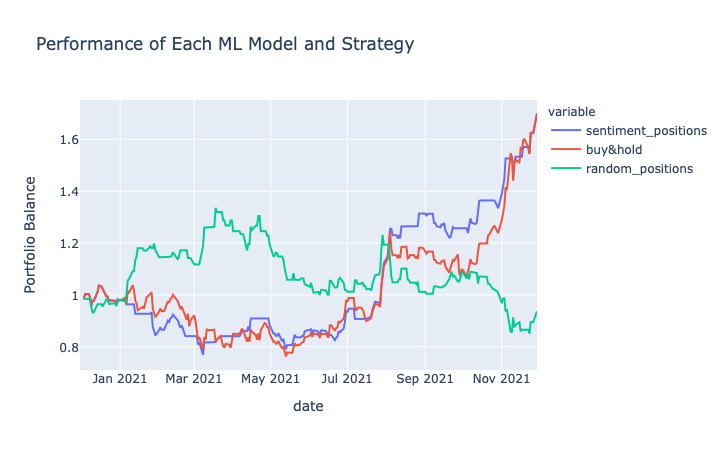

In [85]:
# Visualizing results
fig = px.line(
    performance,
    x=performance.index,
    y=performance.columns,
    title='Performance of Each ML Model and Strategy',
    labels={"value": "Portfolio Balance",
            "ds": "Date"}
)

fig.show()